In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from numba import jit

In [2]:
@jit(nopython = True) 
def IsValid(Rx,Ry,R, r, N):
    Valid = True
    for i in range(N):
        dist = np.sqrt( (R[i,0] - Rx)**2 + (R[i,1] - Ry)**2 )
        if dist < r[i]+r[N]:
            Valid = False
            break   
    return Valid

#Placing N particles randomly without overlaps
def GetPositions(N,r):
    R = np.zeros((N,2))
    R[0,0] = np.random.uniform(0 + r[0], 1 - r[0]) 
    R[0,1] = 0.5*np.random.uniform(0 + r[0], 1 - r[0]) 
    for i in range(1,N):
        Valid = False
        while not(Valid):
            ri = r[i]
            Rnx = np.random.uniform(0 + ri, 1 -ri ) 
            Rny = 0.5*np.random.uniform(0 + ri, 1 - ri)
            Valid = IsValid(Rnx,Rny,R[:i], r, i)
        R[i,:] = [Rnx,Rny]
    return R




#Calculate time to next vertical wall collision
@jit(nopython = True) 
def TimeHitVWall(x, r, vx, N):
    if vx > 0:
        return (1-r-x)/vx
    elif vx < 0:
        return (r-x)/vx
    else: 
        return np.inf
    
#Calculate time to next horizontal wall collision
@jit(nopython = True) 
def TimeHitHWall(y, r, vy, N):        
    if vy > 0:
        return (1-r-y)/vy
    elif vy < 0:
        return (r-y)/vy
    else:
        return np.inf

#Calculate time to next particle-particle collision        
@jit(nopython = True)        
def TimeHitOtherPart(i, R, r, V,N):
    particles = np.arange(N)
    Rij = r[i]+r
    dx =  R[i,0]- R[:,0]
    dy = R[i,1]- R[:,1]
    dvx = V[i,0] - V[:,0]
    dvy = V[i,1] - V[:,1]
    
    drdv = dx*dvx + dy*dvy
    dvdv = dvx**2 + dvy**2
    drdr = dx**2 + dy**2
    d = drdv**2-dvdv*(drdr-Rij**2)
    
    #Collision with that will happen in t<inf
    bdrdv = drdv < 0
    bd = d > 0
    ncol = bdrdv * bd
    dt = -(drdv[ncol]+np.sqrt(d[ncol]))/(dvdv[ncol])
    npar = particles[ncol]
    return dt , npar 

#Finding the earliest valid collision
def EarliestCollision(R, r, V, m, H, Col, xi,time):
    f = True
    while f:
        tmin = heapq.heappop(H)                                                 
        deltat = tmin[0]-time
        a = tmin[1][0]
        b = tmin[1][1]
        c = tmin[1][2]
        if IsValidCol(Col,a,b,c):
            #Move the particles to next collision
            R = R + V*deltat
            f = False
            if a == -1:  
                V[b,0] = -xi*V[b,0]
                V[b,1] = xi*V[b,1]
                return tmin, R, V,(a,b)
                    
        
            elif b == -1:
                V[a,0] = xi*V[a,0]
                V[a,1] = -xi*V[a,1]
                return tmin, R, V,(a,b)
                    
            else:
                dr = r[a] + r[b]
                dR = R[b,:]-R[a,:]
                dV = V[b,:]-V[a,:]
                dvdr = np.dot(dV,dR)
                    
                V[a,:] = V[a,:] + ((1+xi)*(m[b]/(m[a]+m[b]))*((dvdr)/(dr**2)))*dR
                V[b,:] = V[b,:] - ((1+xi)*(m[a]/(m[a]+m[b]))*((dvdr)/(dr**2)))*dR
                return tmin, R, V,(a,b)



def IsValidCol(Col,a,b,c):
    if a == -1:
        if c == Col[b]:
            return True
    elif b == -1:
        if c == Col[a]:
            return True
    else:
        Cn = np.maximum(Col[a],Col[b])
        if c == Cn:
            return True

In [3]:
def FirstCollision(N, R, r, V, m):
    H = []
    Col = np.zeros(N)
    for i in range(N):
        tV = TimeHitVWall(R[i,0], r[i], V[i,0], N)
        tH = TimeHitHWall(R[i,1], r[i], V[i,1], N)
        if tV < np.inf:
            heapq.heappush(H,(tV,[-1,i,0]))
        if tH < np.inf:
            heapq.heappush(H,(tH,[i,-1,0]))
        t,parti = TimeHitOtherPart(i, R, r, V, N)
        for j,el in enumerate(parti):
            heapq.heappush(H,(t[j],[i,el,0]))
    return H, Col


#Finding the new collision after a collision 
def Collision(R, r, V, m, H, tmin, N, Col,c,PartCol):
    c+=1
    a = PartCol[0]
    b = PartCol[1]
    t = tmin[0]
        
    if b == -1:
        Col[a] = c
        tVa = t + TimeHitVWall(R[a,0], r[a], V[a,0], N)
        if tVa < np.inf:
            heapq.heappush(H,(tVa,[-1,a,c]))
            
        tHa = t + TimeHitHWall(R[a,1], r[a], V[a,1], N)
        if tHa < np.inf:
            heapq.heappush(H,(tHa,[a,-1,c]))
                
        time, index = HitOtherPar(a,R,V,r,N,c)
        #Adding the particle-particle collisions to the heap
        for j,el in enumerate(index):
            heapq.heappush(H,(time[j]+t,[a,el,c]))
            
            
    elif a == -1:
        Col[b] = c
        tVb = t + TimeHitVWall(R[b,0], r[b], V[b,0], N)
        if tVb < np.inf:
            heapq.heappush(H,(tVb,[-1,b,c]))
        tHb = t + TimeHitHWall(R[b,1], r[b], V[b,1], N)
        if tHb < np.inf:
            heapq.heappush(H,(tHb,[b,-1,c]))
                
        time, index = HitOtherPar(b,R,V,r,N,c)
        #Adding the particle-particle collisions to the heap
        for j,el in enumerate(index):
            heapq.heappush(H,(time[j]+t,[b,el,c]))
            

    else:
## Particels hits Vwall
        Col[a] = c
        Col[b] = c
        tVa = t + TimeHitVWall(R[a,0], r[a], V[a,0], N)
        if tVa < np.inf:
            heapq.heappush(H,(tVa,[-1,a,c]))
                
        tVb = t + TimeHitVWall(R[b,0], r[b], V[b,0], N)
        if tVb < np.inf:
            heapq.heappush(H,(tVb,[-1,b,c]))
## Particels hits Hwall            
        tHa = t + TimeHitHWall(R[a,1], r[a], V[a,1], N)
        if tHa < np.inf:
            heapq.heappush(H,(tHa,[a,-1,c]))
            
        tHb = t + TimeHitHWall(R[b,1], r[b], V[b,1], N)
        if tHb < np.inf:
            heapq.heappush(H,(tHb,[b,-1,c]))

#Collide with other particels
            
        time,index= HitOtherPar(a,R,V,r,N,c)
        time2,index2= HitOtherPar(b,R,V,r,N,c)
        #Adding the particle-particle collisions to the heap
        for j,el1 in enumerate(index):
            heapq.heappush(H,(time[j]+t,[a,el1,c]))
        for j,el2 in enumerate(index2):
            heapq.heappush(H,(time2[j]+t,[b,el2,c]))
            
    return H,c

#Calculate all the particle-particle collisions with a given particle
def HitOtherPar(a,R,V,r,N,c):
    time, npart = TimeHitOtherPart(a, R, r, V, N)
    return time, npart  

In [4]:
@jit(nopython = True)
def KineticEnergy(V,m,N):
    return np.sum(0.5*(V[:,0]**2+V[:,1]**2)*m[:])

def FindSizeOfCrater(R0,R,N):
    i = 0
    d = np.sqrt(np.sum((R0-R)**2,axis = 1))
    for el in d:
        if el>0.001:
            i+=1
    return i*(0.5/N)

def ManyCollision(N, R, V, r, m,xi):
    E0 = KineticEnergy(V,m,N)
    H,Col = FirstCollision(N, R, r, V, m)
    tmin,R,V,PartCol = EarliestCollision(R, r, V, m, H,Col, xi,0)
    E = KineticEnergy(V,m,N)
    c = 0
    up=0.65
    down = 0.64
    while E > 0.1 * E0:
        H,c = Collision(R, r, V, m, H, tmin, N,Col,c,PartCol)
        tmin,R,V,PartCol = EarliestCollision(R, r, V, m, H, Col,xi,tmin[0])
        E = KineticEnergy(V,m,N)
       # print('Energy: %.3e'% E,'\r',end ='')
    return R,V

In [5]:
N=3000
xi = 0.5

r = np.ones(N)/np.sqrt((4*N*np.pi))
m = np.ones(N)
m[0] = 25

R0 = np.zeros((N,2))
R0[1:N,:] = GetPositions(N-1, r[1:])
R0[0,:] = [0.5, 0.75] 


p = 15

sr = np.zeros(p)
ra = np.linspace(5,50,p)

for i in range(p):
    r[0] = ra[i]*r[1]
    V0 = np.zeros((N,2))
    V0[0,:] = [0,-5]
    R,V = ManyCollision(N, R0, V0, r, m, xi)
    sr[i] = FindSizeOfCrater(R0,R,N)

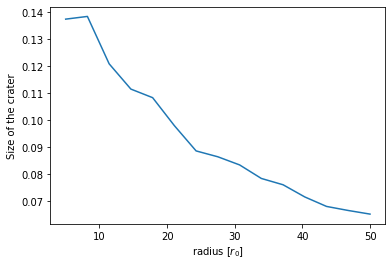

In [6]:
plt.plot(ra,sr)

plt.xlabel('radius [$r_0$]')
plt.ylabel('Size of the crater')
plt.savefig(f'Problem4_radius.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()